In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# ANÁLISIS DE LA RENTABILIDAD Y RIESGO DE UNA CARTERA DE DOS ACTIVOS II

En este notebook vamos a analizar la rentabilidad y riesgo de una cartera de dos activos con precios reales. Para ello, vamos a utilizar los datos de los precios de cierre ajustados.

En este caso, no tendremos activos con correlaciones exactas a las usadas en el notebook anterior, pero sí con correlaciones parecidas.

* En primer lugar, vamos a importar las librerías necesarias y los datos.

* En segundo lugar, vamos a analizar un poco los precios de los activos.





In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import dibuja_covar
import cvxpy as cp

plt.style.use('ggplot')

In [3]:
# Cargamos los datos
precios_pos_df = pd.read_csv('../data/precios_corr_pos.csv', index_col=0, parse_dates=True)
precios_neg_df = pd.read_csv('../data/precios_corr_neg.csv', index_col=0, parse_dates=True)
precios_cero_df = pd.read_csv('../data/precios_corr_cero.csv', index_col=0, parse_dates=True)

In [4]:
precios_pos_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,113.192375,156.263037
2010-01-06,111.121152,155.307702
2010-01-07,107.084666,153.467719
2010-01-08,105.076790,152.540900


In [5]:
precios_neg_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,113.169161,159.774582
2010-01-06,111.074723,160.767536
2010-01-07,107.015024,162.645138
2010-01-08,104.983933,163.609577


In [6]:
precios_cero_df.head()

,Activo 1,Activo 2
2010-01-04,117.000000,158.000000
2010-01-05,120.993339,158.417089
2010-01-06,123.250277,160.666274
2010-01-07,127.472476,159.712392
2010-01-08,129.666067,159.580555


In [7]:
# Calcular los retornos logarítmicos para precios_pos_df
retornos_pos_df = np.log(precios_pos_df).diff().dropna()

# Calcular los retornos logarítmicos para precios_neg_df
retornos_neg_df = np.log(precios_neg_df).diff().dropna()

# Calcular los retornos logarítmicos para precios_cero_df
retornos_cero_df = np.log(precios_cero_df).diff().dropna()


In [8]:
# Calcular la media y la desviación estándar de los retornos
med_pos = retornos_pos_df.mean()
med_neg = retornos_neg_df.mean()
med_cero = retornos_cero_df.mean()

std_pos = retornos_pos_df.std()
std_neg = retornos_neg_df.std()
std_cero = retornos_cero_df.std()


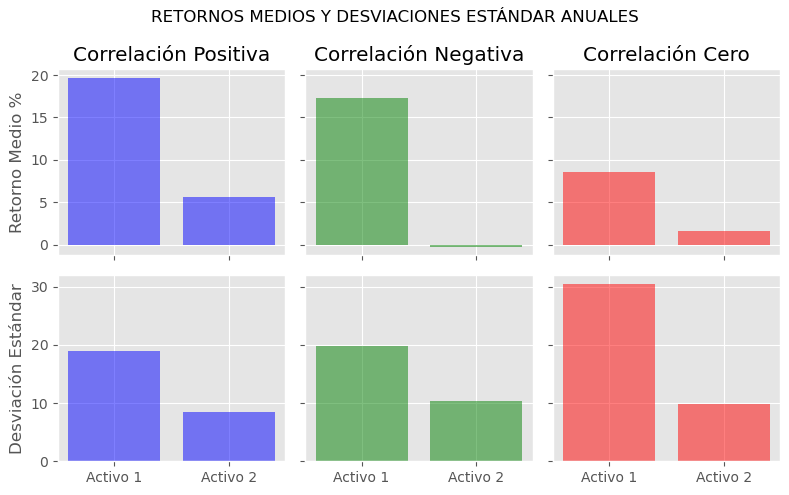

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey='row')

# Gráfico de barras para los retornos medios
axs[0, 0].bar(med_pos.index, 100*252*med_pos.values, color='blue', alpha=0.5)
axs[0, 0].set_title('Correlación Positiva')
axs[0, 0].set_ylabel('Retorno Medio %')

# Gráfico de barras para las desviaciones estándar
axs[0, 1].bar(med_neg.index, 100*252*med_neg.values, color='green', alpha=0.5)
axs[0, 1].set_title('Correlación Negativa')


axs[0, 2].bar(med_cero.index, 100*252*med_cero.values, color='red', alpha=0.5)
axs[0, 2].set_title('Correlación Cero')


# Gráfico de barras para las desviaciones estándar
axs[1, 0].bar(std_pos.index, 100*np.sqrt(252)*std_pos.values, color='blue', alpha=0.5)
axs[1, 0].set_ylabel('Desviación Estándar')


axs[1, 1].bar(std_neg.index, 100*np.sqrt(252)*std_neg.values, color='green', alpha=0.5)


axs[1, 2].bar(std_cero.index, 100*np.sqrt(252)*std_cero.values, color='red', alpha=0.5)


plt.suptitle('RETORNOS MEDIOS Y DESVIACIONES ESTÁNDAR ANUALES')


# Ajuste final
plt.tight_layout()
plt.show()

Veamos ahora la serie de tiempos de los precios de los activos.

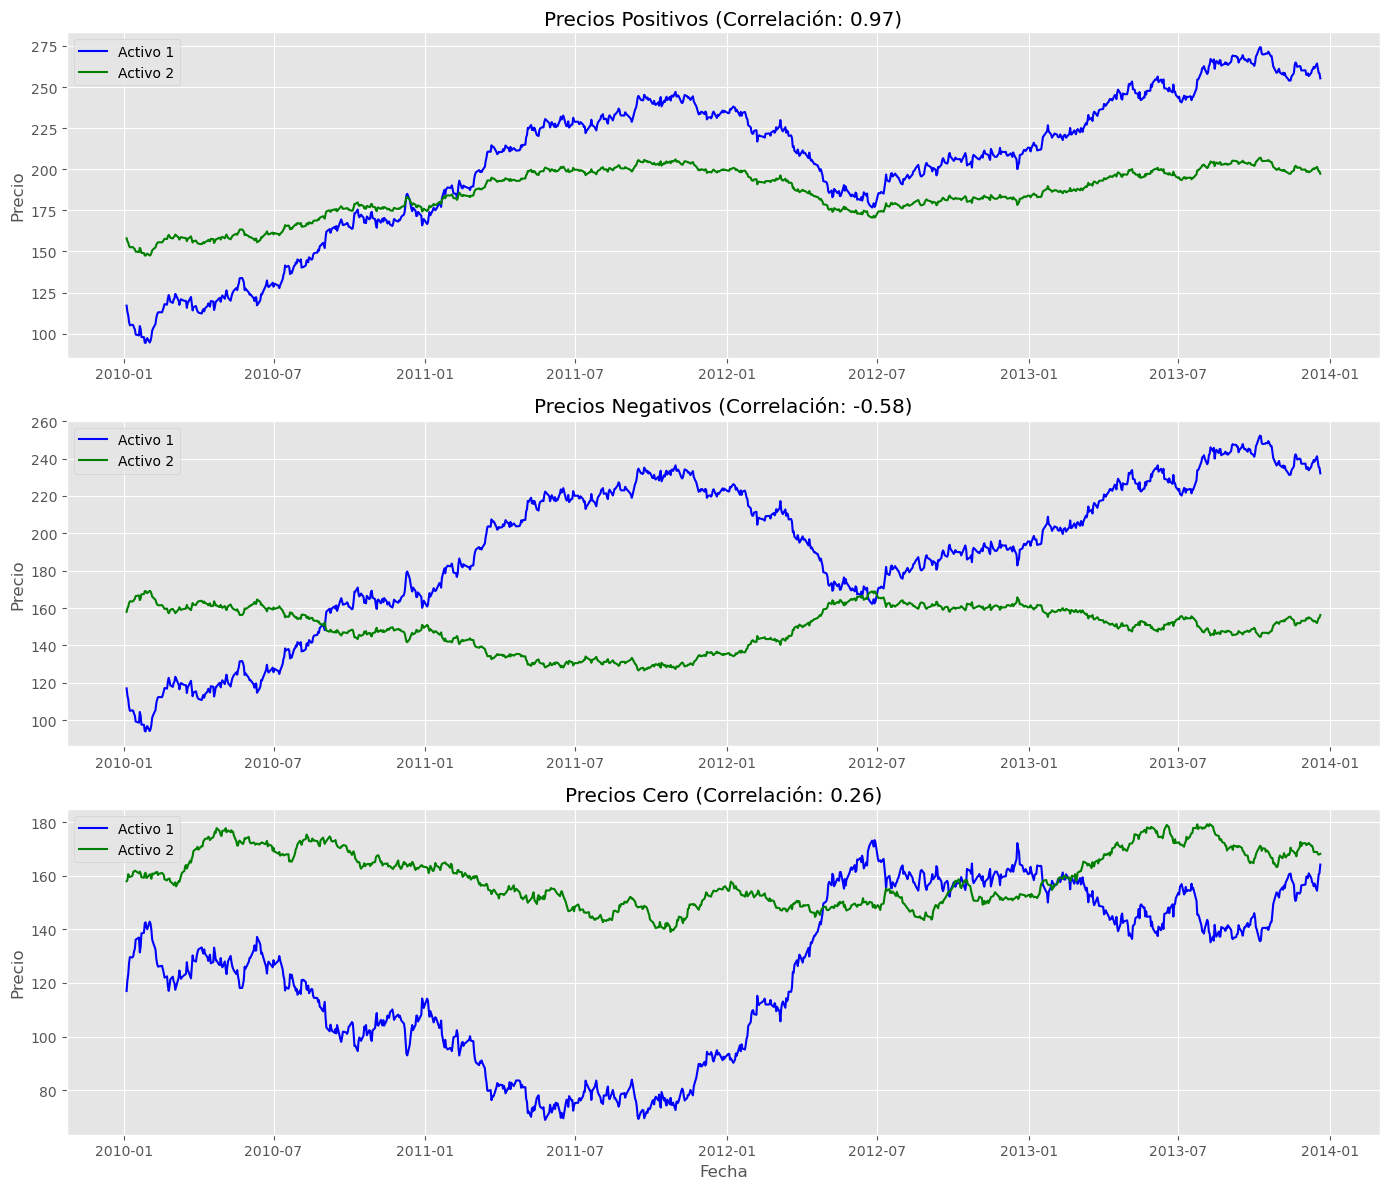

In [10]:
# Inicializar figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Graficar precios_pos_df y mostrar coeficiente de correlación en el título
corr_pos = precios_pos_df.corr().iloc[0, 1]
axes[0].plot(precios_pos_df['Activo 1'], label='Activo 1', color='blue')
axes[0].plot(precios_pos_df['Activo 2'], label='Activo 2', color='green')
axes[0].set_title(f'Precios Positivos (Correlación: {corr_pos:.2f})')
axes[0].set_ylabel('Precio')
axes[0].legend()
axes[0].grid(True)

# Graficar precios_neg_df y mostrar coeficiente de correlación en el título
corr_neg = precios_neg_df.corr().iloc[0, 1]
axes[1].plot(precios_neg_df['Activo 1'], label='Activo 1', color='blue')
axes[1].plot(precios_neg_df['Activo 2'], label='Activo 2', color='green')
axes[1].set_title(f'Precios Negativos (Correlación: {corr_neg:.2f})')
axes[1].set_ylabel('Precio')
axes[1].legend()
axes[1].grid(True)

# Graficar precios_cero_df y mostrar coeficiente de correlación en el título
corr_cero = precios_cero_df.corr().iloc[0, 1]
axes[2].plot(precios_cero_df['Activo 1'], label='Activo 1', color='blue')
axes[2].plot(precios_cero_df['Activo 2'], label='Activo 2', color='green')
axes[2].set_title(f'Precios Cero (Correlación: {corr_cero:.2f})')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Precio')
axes[2].legend()
axes[2].grid(True)

# Mostrar la figura
plt.tight_layout()
plt.show()


Vamos a generar 1.000 carteras aleatorias, fijando la semilla para poder reproducir los experimentos, para visualizar sus comportamientos de rentabilidad frente a volatilidad.

In [19]:
# Generar pesos aleatorios
num_portfolios = 1000 #
np.random.seed(42)  # Fijar semilla para reproducibilidad
weights = np.random.random(size=(num_portfolios, 2))
weights = weights / np.sum(weights, axis=1)[:, np.newaxis]  # Normalizar para que la suma sea 1

In [20]:
# Función para calcular rentabilidad y riesgo de un activo individual
def asset_performance(returns):
    return returns.mean(), returns.std()

In [21]:
# Función para calcular retornos, rentabilidad y riesgo de la cartera
def portfolio_performance(weights, returns):
    portfolio_returns = returns @ weights.T
    return portfolio_returns.mean(axis=0), portfolio_returns.std(axis=0)

In [22]:
# Función para graficar en un eje específico
def plot_on_axis(ax, ret_mean, ret_std, asset1_mean, asset1_std, asset2_mean, asset2_std, color, marker, label, corr):
    ax.scatter(ret_std, ret_mean, c=color, marker=marker, alpha=0.4, label=label)
    ax.scatter(asset1_std, asset1_mean, c='red', marker='*', s=150, label='Activo 1')
    ax.scatter(asset2_std, asset2_mean, c='green', marker='*', s=150, label='Activo 2')
    ax.set_title(f'{label} (Correlación: {corr:.2f})')
    ax.set_xlabel('Riesgo (Desviación Estándar)')
    ax.set_ylabel('Rentabilidad (Retorno Medio)')
    ax.legend(loc='upper left')
    ax.grid(True)

In [23]:
# Calculamos los retornos logarítmicos para cada dataframe
retornos_pos_df = np.log(precios_pos_df).diff().dropna()
retornos_neg_df = np.log(precios_neg_df).diff().dropna()
retornos_cero_df = np.log(precios_cero_df).diff().dropna()

In [24]:
# Calcular rentabilidad y riesgo para cada activo individual
asset1_pos_mean, asset1_pos_std = asset_performance(retornos_pos_df['Activo 1'])
asset2_pos_mean, asset2_pos_std = asset_performance(retornos_pos_df['Activo 2'])

asset1_neg_mean, asset1_neg_std = asset_performance(retornos_neg_df['Activo 1'])
asset2_neg_mean, asset2_neg_std = asset_performance(retornos_neg_df['Activo 2'])

asset1_cero_mean, asset1_cero_std = asset_performance(retornos_cero_df['Activo 1'])
asset2_cero_mean, asset2_cero_std = asset_performance(retornos_cero_df['Activo 2'])

In [25]:
# Calcular rendimientos de cartera, rentabilidad y riesgo para cada dataframe
ret_pos_mean, ret_pos_std = portfolio_performance(weights, retornos_pos_df)
ret_neg_mean, ret_neg_std = portfolio_performance(weights, retornos_neg_df)
ret_cero_mean, ret_cero_std = portfolio_performance(weights, retornos_cero_df)

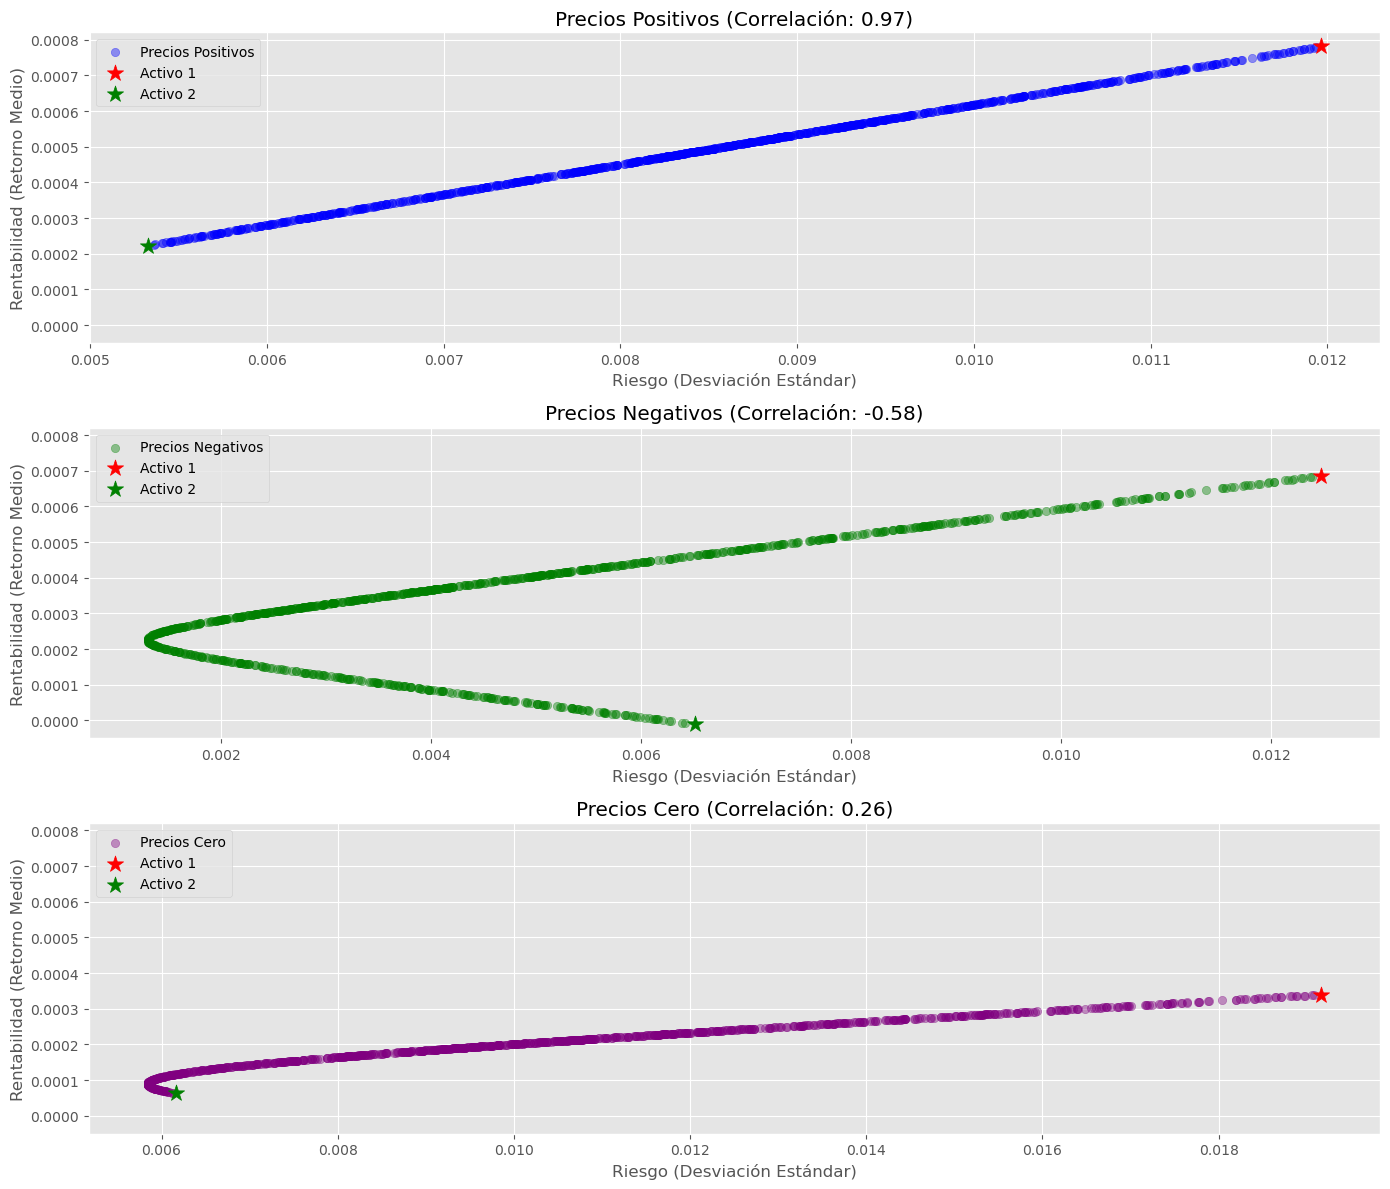

In [26]:
# Inicializar figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharey=True)

# Graficar en cada eje
plot_on_axis(axes[0], ret_pos_mean, ret_pos_std, asset1_pos_mean, asset1_pos_std, asset2_pos_mean, asset2_pos_std, 'blue', 'o', 'Precios Positivos', corr_pos)
plot_on_axis(axes[1], ret_neg_mean, ret_neg_std, asset1_neg_mean, asset1_neg_std, asset2_neg_mean, asset2_neg_std, 'green', 'o', 'Precios Negativos', corr_neg)
plot_on_axis(axes[2], ret_cero_mean, ret_cero_std, asset1_cero_mean, asset1_cero_std, asset2_cero_mean, asset2_cero_std, 'purple', 'o', 'Precios Cero', corr_cero)

plt.tight_layout()
plt.show()